<a href="https://colab.research.google.com/github/PravinVedurla/Pneumonic-Classification-Using-CNN-with-Pytorch/blob/master/Detecting_Pneumonia_using_CNN_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pravinved","key":"0d5f2987f9e9d75297912c03636a0ae5"}'}

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as im


import glob
import os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


In [0]:
os.listdir()

['.config', 'kaggle.json', 'sample_data']

In [0]:
#Installing kaggle dependency.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Ensuring kaggle API has worked properly!
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
bradklassen/pga-tour-20102018-data                          PGA Tour Golf Data                                   92MB  2019-08-20 10:32:59           2989  
AnalyzeBoston/crimes-in-boston                              Crimes in Boston                                     10MB  2018-09-04 17:56:03          10299  
matheusfreitag/gas-prices-in-brazil                         Gas Prices in Brazil                                  3MB  2019-07-12 16:23:52           5578  
jealousleopard/goodreadsbooks                               Goodreads-books                                     632KB  2019-06-14 16:35:05           9397  
wkirgsn/electric-motor-temperature                          Elec

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:25<00:00, 42.5MB/s]
100% 1.15G/1.15G [00:25<00:00, 48.3MB/s]


In [0]:
os.listdir()

['.config', 'chest-xray-pneumonia.zip', 'kaggle.json', 'sample_data']

In [0]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [0]:
!unzip chest_xray.zip

Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUM

In [0]:
os.chdir("/content/chest_xray")
os.listdir()

['test', 'val', '.DS_Store', 'train']

In [0]:
os.getcwd()

'/content/chest_xray'

In [0]:
for dirpath, dirnames,_ in os.walk('/content/chest_xray'):
  print("path:" + str(dirpath))
  print("Dirname:", str(dirnames))

path:/content/chest_xray
Dirname: ['test', 'val', 'train']
path:/content/chest_xray/test
Dirname: ['NORMAL', 'PNEUMONIA']
path:/content/chest_xray/test/NORMAL
Dirname: []
path:/content/chest_xray/test/PNEUMONIA
Dirname: []
path:/content/chest_xray/val
Dirname: ['NORMAL', 'PNEUMONIA']
path:/content/chest_xray/val/NORMAL
Dirname: []
path:/content/chest_xray/val/PNEUMONIA
Dirname: []
path:/content/chest_xray/train
Dirname: ['NORMAL', 'PNEUMONIA']
path:/content/chest_xray/train/NORMAL
Dirname: []
path:/content/chest_xray/train/PNEUMONIA
Dirname: []


In [0]:
#Defining all the directories beforehand
base_dir = '/content/chest_xray'

train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'

train_pneumonia_dir = '/content/chest_xray/train/PNEUMONIA'
test_pneumonia_dir = '/content/chest_xray/test/PNEUMONIA'
val_pneumonia_dir = '/content/chest_xray/val/PNEUMONIA'

train_normal_dir = '/content/chest_xray/train/NORMAL'
test_normal_dir = '/content/chest_xray/test/NORMAL'
val_normal_dir = '/content/chest_xray/val/NORMAL'


In [0]:
print("Number of training examples : \n Pneumonia : ", len(os.listdir(train_pneumonia_dir)) ,"\n Normal:", len(os.listdir(train_normal_dir)))
print("Number of test examples : \n Pneumonia :", len(os.listdir(test_pneumonia_dir)), "\n Normal:", len(os.listdir(test_normal_dir)))
print("Number of validation examples : \n Pneumonia :", len(os.listdir(val_pneumonia_dir)), "\n Normal:", len(os.listdir(val_normal_dir)))

Number of training examples : 
 Pneumonia :  3876 
 Normal: 1342
Number of test examples : 
 Pneumonia : 390 
 Normal: 234
Number of validation examples : 
 Pneumonia : 9 
 Normal: 9


## We can clearly observe that the number of training and test examples for the Non_Pneumonic set is almost 3 times lower than the Pneumonic set. 

### Images from the normal part of the data need to be augmented.

In [0]:
# filesbefore = os.listdir(train_normal_dir)

In [0]:
# from shutil import copyfile

# for z in range(2):
#   for i,f in enumerate(filesbefore):
#     ori = os.path.join(train_normal_dir, f)
#     cpy = os.path.join(train_normal_dir, "COPIED_" + str(z) +"_"+ str(i) + f )
#     copyfile(ori, cpy)
# len(os.listdir(train_normal_dir))

In [0]:
# filesafter = os.listdir(train_normal_dir)
# augfiles = []

# for f in filesafter:
#   if 'COPIED_' in f:
#     augfiles.append(os.path.join(train_normal_dir, f))

# len(augfiles)

# Now we have indices to all the new copied files from the wd that are ready to be augmented. Now we need to read these files and 

In [0]:
# from os.path import isfile, join

# import imgaug as ia
# from imgaug import augmenters as iaa
# import imageio

# import numpy as np
# import scipy.misc

In [0]:
# file_names = os.listdir(train_normal_dir)
# files = [ join(train_normal_dir, i) for i in file_names ]

# len(files)

In [0]:
# imagelist = list()

# for f in files: #iterates over all the file directories in the full list
    
#     image = imageio.imread(f) #reads the image at the destination of the directory it stumbles on
#     imagelist.append(image) #adds the image to a list grouping them all together.

# Using 'Augmentor' Package.

In [0]:
!pip install Augmentor

In [0]:
import Augmentor

In [0]:
p = Augmentor.Pipeline(train_normal_dir, save_format='PNG')

Initialised with 1341 image(s) found.
Output directory set to /content/chest_xray/train/NORMAL/output.

In [0]:
p.rotate180(probability=0.5)
p.skew(probability=0.5, magnitude=0.3)
p.random_distortion(probability=0.2, magnitude=3, grid_height=16, grid_width=16)
p.shear(probability=0.5, max_shear_left=3, max_shear_right=3)
p.crop_random(probability=0.3, percentage_area=0.8)
p.flip_top_bottom(probability=0.7)

In [0]:
p.sample(2700)

Processing <PIL.Image.Image image mode=L size=1675x1428 at 0x7FD9576375F8>: 100%|██████████| 2700/2700 [17:13<00:00,  2.61 Samples/s]


In [0]:
len(os.listdir(train_normal_dir + "/output"))

2700

In [0]:
import shutil
mypath = train_normal_dir + "/output"
files = os.listdir(mypath)
#files.sort()
for f in files:
    src = os.path.join(mypath, f)
    dst = os.path.join(train_normal_dir, f)
    shutil.move(src,dst)

In [0]:
# for f in os.listdir(train_normal_dir + "/output"):
#   os.system(f"mv {f} NORMAL")

In [0]:
len(os.listdir(train_normal_dir))

4043

In [0]:
import random
def randomly(range1):
  r = list(range(range1))
  random.shuffle(r)
  return r

In [0]:
r = randomly(4043)
files = os.listdir(train_normal_dir)
for i,a in zip(r, range(100)):
  f = files[i]
  src = os.path.join(train_normal_dir, f)
  dst = os.path.join(test_normal_dir, f)
  shutil.move(src,dst)


In [0]:
len(os.listdir(test_normal_dir))

334

# Number of training we get after Augmenting the data available.

In [0]:
print("Number of training examples : \n Pneumonia : ", len(os.listdir(train_pneumonia_dir)) ,"\n Normal:", len(os.listdir(train_normal_dir)))
print("Number of test examples : \n Pneumonia :", len(os.listdir(test_pneumonia_dir)), "\n Normal:", len(os.listdir(test_normal_dir)))
print("Number of validation examples : \n Pneumonia :", len(os.listdir(val_pneumonia_dir)), "\n Normal:", len(os.listdir(val_normal_dir)))

Number of training examples : 
 Pneumonia :  3876 
 Normal: 3943
Number of test examples : 
 Pneumonia : 390 
 Normal: 334
Number of validation examples : 
 Pneumonia : 9 
 Normal: 9


In [0]:
fnames = os.listdir(train_pneumonia_dir)
for i,f in enumerate(fnames):
  f1 = os.path.join(train_pneumonia_dir, f)
  fnames[i] = f1

fnames


['/content/chest_xray/train/PNEUMONIA/person1924_bacteria_4832.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person579_bacteria_2383.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person669_bacteria_2561.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person1418_bacteria_3638.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person842_bacteria_2762.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person255_bacteria_1161.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person803_bacteria_2710.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person732_virus_1353.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person1257_bacteria_3215.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person23_bacteria_80.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person911_bacteria_2836.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person88_virus_165.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person263_bacteria_1227.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person1601_bacteria_4209.jpeg',
 '/content/chest_xray/train/PNEUMONIA/per

In [0]:
len(fnames)

3876

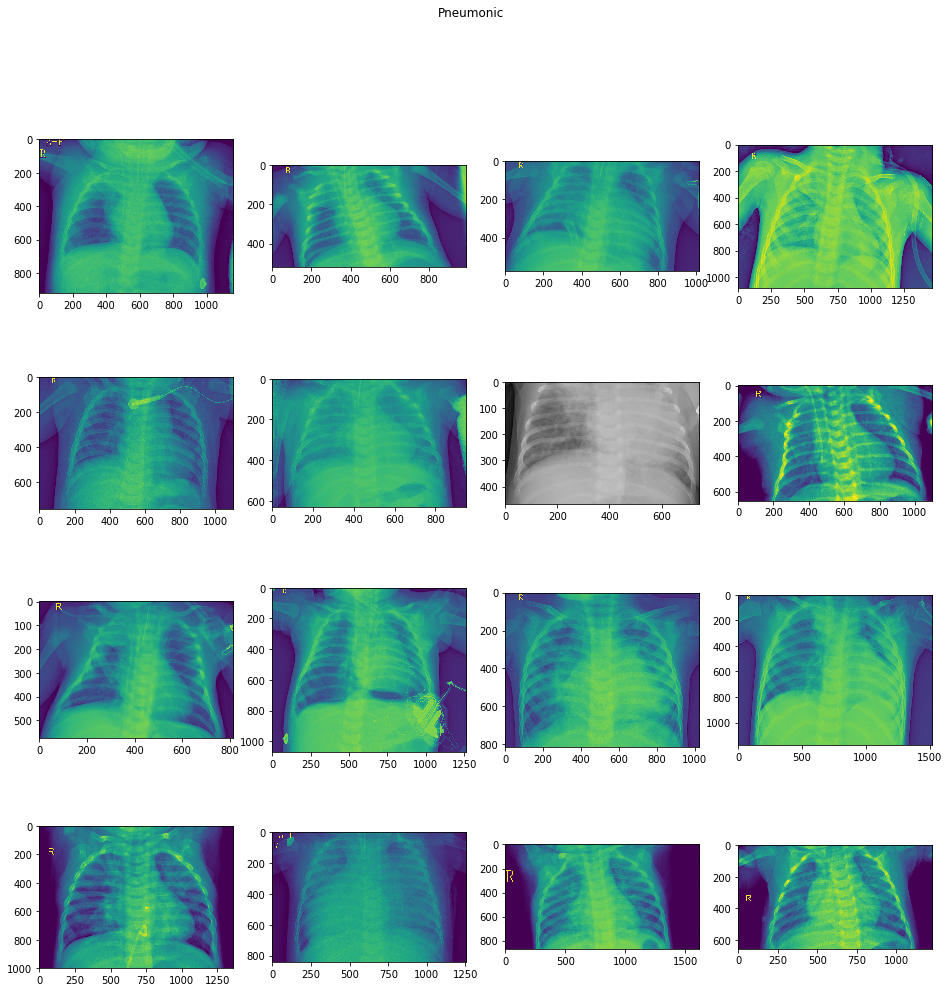

In [0]:
#fig=plt.figure(figsize=(8, 8))
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i,img_path in enumerate(fnames[:16]):
  
  sp = plt.subplot(nrows, ncols, i + 1) #since the indices for subplot start at 1
  
  img = im.imread(img_path)
  plt.imshow(img)
plt.suptitle("Pneumonic")
plt.show()

In [0]:
len(os.listdir(train_pneumonia_dir))

3876

In [0]:
a = randomly(3876)[0]
a

3410

IndexError: ignored

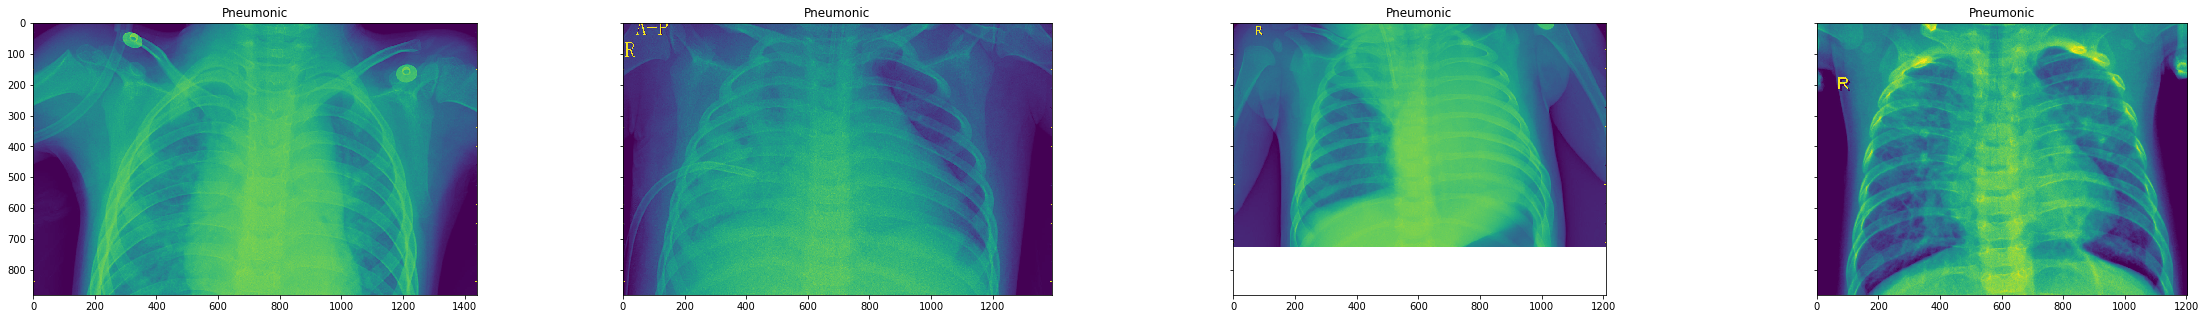

In [0]:

start_idx=100
nrows=1
num_img=8
fig, ax = plt.subplots(nrows=nrows, ncols=4, sharey=True, figsize=(num_img*5,5))

for i,z in enumerate(glob.glob(train_pneumonia_dir + '/*')[start_idx:start_idx+num_img]):
  img = im.imread(z)
  ax[i].imshow(img)
  ax[i].set_title('Pneumonic')
#plt.show()
  

# Extracting a pretrained model to train it by the data preprocessed earlier.

In [0]:
#Defining transforms and data loaders.

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [0]:
# Device shifts to GPU is it's available or stays with CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [0]:
# Defining Model as Resnet50 pretrained and extracted from Models of torchvision
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 62686959.68it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
model.fc = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))

In [0]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax()
)

In [0]:
# Defining Loss criterion and Optimiser
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.fc.parameters(), lr=0.003)

# Moves the model to either CPU or GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
traininglosses =[]
testinglosses= []
testaccuracy= []
totalsteps= []

epochs = 3
steps = 0
runn = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)
        
        optimiser.zero_grad()
        
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        
        optimiser.step()
        
        runn += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            test_loss = 0
            acc = 0
            
            for images, labels in testloader:
                
                images, labels= images.to(device), labels.to(device)
                
                logps = model(images)
                loss = criterion(logps, labels)
                test_loss += loss.item()
                
                ps = torch.exp(logps)
                top_ps, top_c = ps.topk(1, dim=1)
                equal = top_c == labels.view(top_c.shape)
                acc += torch.mean(equal.type(torch.FloatTensor)).item()
                
            traininglosses.append(runn/print_every)
            testinglosses.append(test_loss/len(testloader))
            testaccuracy.append(acc/len(testloader))
            totalsteps.append(steps)    
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {runn/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {acc/len(testloader):.3f}")
            runn = 0
            model.train()

Epoch 1/3.. Train loss: 2.175.. Test loss: 2.406.. Test accuracy: 0.546
Epoch 1/3.. Train loss: 1.037.. Test loss: 0.698.. Test accuracy: 0.600
Epoch 1/3.. Train loss: 0.567.. Test loss: 0.530.. Test accuracy: 0.750
Epoch 1/3.. Train loss: 0.468.. Test loss: 1.085.. Test accuracy: 0.557
Epoch 1/3.. Train loss: 0.614.. Test loss: 0.440.. Test accuracy: 0.802
Epoch 1/3.. Train loss: 0.514.. Test loss: 0.488.. Test accuracy: 0.764
Epoch 1/3.. Train loss: 0.429.. Test loss: 0.443.. Test accuracy: 0.801
Epoch 1/3.. Train loss: 0.307.. Test loss: 0.650.. Test accuracy: 0.714
Epoch 1/3.. Train loss: 0.324.. Test loss: 0.468.. Test accuracy: 0.823
Epoch 1/3.. Train loss: 0.344.. Test loss: 0.536.. Test accuracy: 0.784
Epoch 1/3.. Train loss: 0.255.. Test loss: 0.452.. Test accuracy: 0.830
Epoch 1/3.. Train loss: 0.380.. Test loss: 0.448.. Test accuracy: 0.832
Epoch 1/3.. Train loss: 0.432.. Test loss: 0.431.. Test accuracy: 0.846
Epoch 1/3.. Train loss: 0.342.. Test loss: 0.421.. Test accuracy

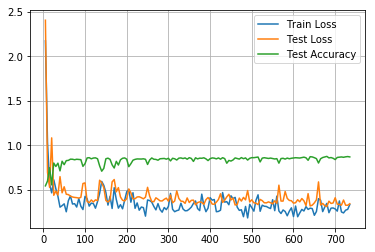

In [0]:
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.plot(totalsteps, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()

In [0]:
checkpoint = {
    'parameters' : model.parameters,
    'state_dict' : model.state_dict()
}


torch.save(checkpoint, './pneumonicVersion1.pth')

In [0]:
files.download('./pneumonicVersion1.pth')